## Model 2

This model expects the files to be in a slightly different file structure detailed below:

 - Skull-Stripping-CNN-Repo

    - torch_preProcessing2.ipynb
    
    - data
        - files
            - all of the .nii.gz files (do not unzip them)
        - labels.csv
        
      
The scripts in /processing_scripts were used to extract the new perfect scans into the proper file structure & generate the labels for them. 

Otherwise everything else should be pretty similar if not the same
 

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import Softmax
from torch.nn.modules.activation import ReLU
from torchsummary import summary

import nibabel as nib
import matplotlib.pyplot as plt
import gzip
import tensorflow as tf
import os
import shutil
import numpy as np
from scipy import ndimage
from tensorflow import keras
from tensorflow.keras import layers
import gc

non-stripped


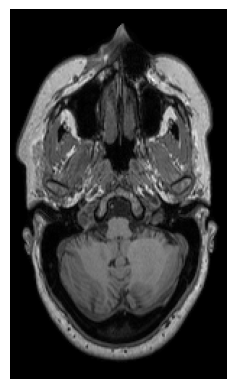

stripped


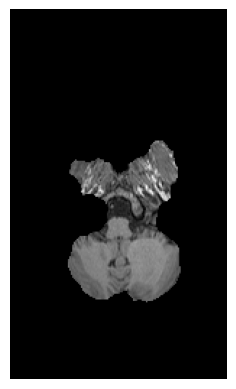

In [20]:
nfilepath = './data/files/IXI369-Guys-0924-T1_bet_03.nii.gz'
sfilepath = './data/files/IXI369-Guys-0924-T1_bet_8.nii.gz'


def process_scan_file(filepath):
    # Load the image data from the file
    image = nib.load(filepath)

    # Get the image data as a numpy array
    data = image.get_fdata()

    # Select the slice index you want to display or save (e.g., slice 20)
    slice_index = 100
    center = 90

    # Display the image data for the selected slice
    plt.imshow(data[:,center,:], cmap='gray')
    plt.axis('off')
    plt.show()

    # Save the image for the selected slice as JPEG
    # plt.imsave(f'slice_{center}.jpg', data[:,center,:], cmap='gray')

    
print("non-stripped")
process_scan_file(nfilepath)

print("stripped")
process_scan_file(sfilepath)

In [3]:
# def unzip_files(folderpath):
    
#     for file in os.listdir(folderpath):
#         filepath = os.path.join(folderpath, file)
    
#         with gzip.open(filepath, 'rb') as f_in:
#             outpath = os.path.splitext(filepath)[0]
#             print(f"outpath: {outpath} | filename: {file[:-3]}")
#             outputfolder = os.path.join("./image_data/BSE_BET_DATA/nifti_files", file[:-3])
#             with open(outputfolder, 'wb') as f_out:
#                 f_out.write(f_in.read())
#         print(file)
    

def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def display_scan(data):
    # Select the slice index you want to display or save (e.g., slice 20)
    slice_index = 100
    center = 32

    # Display the image data for the selected slice
    plt.imshow(data[:,:,center], cmap='gray')
    plt.axis('off')
    plt.show()

    # Save the image for the selected slice as JPEG
    plt.imsave(f'slice_{center}.jpg', data[:,center,:], cmap='gray')


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    
    return volume

In [16]:
#folderpath = "./data/files"
nifti_folder = "./data/files"

# uncomment this if you haven't unzipped the folders
#unzip_files(folderpath)

for file in os.listdir(nifti_folder):
    path = os.path.join(nifti_folder, file)
    img = process_scan(path)
    print(img.shape)
    print(file)

(128, 128, 64)
IXI084-Guys-0741-T1_bse_less_s47_r1.nii.gz
(128, 128, 64)
IXI080-HH-1341-T1_bet_89.nii.gz
(128, 128, 64)
IXI524-HH-2412-T1_bet_07.nii.gz
(128, 128, 64)
IXI363-HH-2050-T1_bet_73.nii.gz
(128, 128, 64)
IXI611-HH-2650-T1_bet_83.nii.gz
(128, 128, 64)
IXI633-HH-2689-T1_bse_high_s78_r2.nii.gz
(128, 128, 64)
IXI089-Guys-0757-T1_bse_less_s51_r1.nii.gz
(128, 128, 64)
IXI415-Guys-0942-T1_bet_2.nii.gz
(128, 128, 64)
IXI548-IOP-1150-T1_bse_less_s48_r1.nii.gz
(128, 128, 64)
IXI403-Guys-0965-T1_bet_1.nii.gz
(128, 128, 64)
IXI394-Guys-0940-T1_bet_5.nii.gz
(128, 128, 64)
IXI157-Guys-0816-T1_bse_high_s74_r2.nii.gz
(128, 128, 64)
IXI070-Guys-0767-T1_bse_default.nii.gz
(128, 128, 64)
IXI216-HH-1635-T1_bet_82.nii.gz
(128, 128, 64)
IXI196-Guys-0805-T1_bse_high_s9_r2.nii.gz
(128, 128, 64)
IXI428-Guys-0996-T1_bse_high_s85_r2.nii.gz
(128, 128, 64)
IXI088-Guys-0758-T1_bse_default.nii.gz
(128, 128, 64)
IXI512-Guys-1054-T1_bse_high_s79_r2.nii.gz
(128, 128, 64)
IXI423-IOP-0974-T1_bet_5.nii.gz
(128, 

(128, 128, 64)
IXI490-Guys-1018-T1_bet_71.nii.gz
(128, 128, 64)
IXI611-HH-2650-T1_bse_high_s84_r2.nii.gz
(128, 128, 64)
IXI598-HH-2606-T1_bse_high_s85_r2.nii.gz
(128, 128, 64)
IXI651-Guys-1118-T1_bet_82.nii.gz
(128, 128, 64)
IXI223-Guys-0830-T1_bet_16.nii.gz
(128, 128, 64)
IXI179-Guys-0777-T1_bse_default.nii.gz
(128, 128, 64)
IXI157-Guys-0816-T1_bet_72.nii.gz
(128, 128, 64)
IXI302-HH-1883-T1_bet_81.nii.gz
(128, 128, 64)
IXI550-Guys-1069-T1_bse_default.nii.gz
(128, 128, 64)
IXI552-Guys-1063-T1_bet_77.nii.gz
(128, 128, 64)
IXI320-Guys-0902-T1_bse_default.nii.gz
(128, 128, 64)
IXI542-IOP-1147-T1_bse_less_s41_r1.nii.gz
(128, 128, 64)
IXI066-Guys-0731-T1_bet_5.nii.gz
(128, 128, 64)
IXI013-HH-1212-T1_bet_19.nii.gz
(128, 128, 64)
IXI350-Guys-0908-T1_bet_5.nii.gz
(128, 128, 64)
IXI601-HH-2700-T1_bse_high_s72_r2.nii.gz
(128, 128, 64)
IXI538-HH-2411-T1_bse_default.nii.gz
(128, 128, 64)
IXI338-HH-1971-T1_bse_high_s77_r2.nii.gz
(128, 128, 64)
IXI021-Guys-0703-T1_bse_default.nii.gz
(128, 128, 64)
I

(128, 128, 64)
IXI146-HH-1389-T1_bet_84.nii.gz
(128, 128, 64)
IXI219-Guys-0894-T1_bse_less_s47_r1.nii.gz
(128, 128, 64)
IXI206-HH-1650-T1_bet_5.nii.gz
(128, 128, 64)
IXI455-Guys-0981-T1_bse_less_s41_r1.nii.gz
(128, 128, 64)
IXI023-Guys-0699-T1_bse_default.nii.gz
(128, 128, 64)
IXI452-HH-2213-T1_bet_86.nii.gz
(128, 128, 64)
IXI464-IOP-1029-T1_bet_84.nii.gz
(128, 128, 64)
IXI420-Guys-1028-T1_bet_5.nii.gz
(128, 128, 64)
IXI368-Guys-0916-T1_bet_2.nii.gz
(128, 128, 64)
IXI389-Guys-0930-T1_bet_15.nii.gz
(128, 128, 64)
IXI136-HH-1452-T1_bet_73.nii.gz
(128, 128, 64)
IXI460-Guys-0999-T1_bse_less_s43_r1.nii.gz
(128, 128, 64)
IXI596-IOP-1160-T1_bet_73.nii.gz
(128, 128, 64)
IXI141-Guys-0789-T1_bse_less_s57_r1.nii.gz
(128, 128, 64)
IXI232-IOP-0898-T1_bet_12.nii.gz
(128, 128, 64)
IXI500-Guys-1017-T1_bet_5.nii.gz
(128, 128, 64)
IXI102-HH-1416-T1_bet_85.nii.gz
(128, 128, 64)
IXI051-HH-1328-T1_bse_less_s49_r1.nii.gz
(128, 128, 64)
IXI098-Guys-0745-T1_bse_high_s82_r2.nii.gz
(128, 128, 64)
IXI554-Guys-10

(128, 128, 64)
IXI256-HH-1723-T1_bet_81.nii.gz
(128, 128, 64)
IXI336-Guys-0904-T1_bse_less_s56_r1.nii.gz
(128, 128, 64)
IXI049-HH-1358-T1_bet_5.nii.gz
(128, 128, 64)
IXI532-IOP-1145-T1_bet_5.nii.gz
(128, 128, 64)
IXI369-Guys-0924-T1_bse_default.nii.gz
(128, 128, 64)
IXI542-IOP-1147-T1_bet_5.nii.gz
(128, 128, 64)
IXI035-IOP-0873-T1_bet_15.nii.gz
(128, 128, 64)
IXI159-HH-1549-T1_bse_default.nii.gz
(128, 128, 64)
IXI491-Guys-1032-T1_bse_less_s43_r1.nii.gz
(128, 128, 64)
IXI435-IOP-1040-T1_bet_5.nii.gz
(128, 128, 64)
IXI462-IOP-1042-T1_bse_high_s85_r2.nii.gz
(128, 128, 64)
IXI507-Guys-1036-T1_bet_18.nii.gz
(128, 128, 64)
IXI541-IOP-1146-T1_bet_73.nii.gz
(128, 128, 64)
IXI153-Guys-0782-T1_bse_less_s43_r1.nii.gz
(128, 128, 64)
IXI173-HH-1590-T1_bse_less_s4_r1.nii.gz
(128, 128, 64)
IXI279-Guys-1044-T1_bse_high_s72_r2.nii.gz
(128, 128, 64)
IXI227-Guys-0813-T1_bse_less_s59_r1.nii.gz
(128, 128, 64)
IXI491-Guys-1032-T1_bse_high_s76_r2.nii.gz
(128, 128, 64)
IXI089-Guys-0757-T1_bet_5.nii.gz
(128, 1

(128, 128, 64)
IXI402-Guys-0961-T1_bse_less_s42_r1.nii.gz
(128, 128, 64)
IXI250-Guys-0836-T1_bse_high_s86_r2.nii.gz
(128, 128, 64)
IXI598-HH-2606-T1_bet_09.nii.gz
(128, 128, 64)
IXI467-Guys-0983-T1_bet_2.nii.gz
(128, 128, 64)
IXI369-Guys-0924-T1_bse_less_s53_r1.nii.gz
(128, 128, 64)
IXI467-Guys-0983-T1_bet_5.nii.gz
(128, 128, 64)
IXI119-Guys-0765-T1_bse_less_s51_r1.nii.gz
(128, 128, 64)
IXI462-IOP-1042-T1_bet_15.nii.gz
(128, 128, 64)
IXI151-Guys-0793-T1_bse_default.nii.gz
(128, 128, 64)
IXI562-Guys-1131-T1_bet_87.nii.gz
(128, 128, 64)
IXI307-IOP-0872-T1_bet_05.nii.gz
(128, 128, 64)
IXI287-Guys-0863-T1_bet_02.nii.gz
(128, 128, 64)
IXI131-HH-1527-T1_bet_17.nii.gz
(128, 128, 64)
IXI595-IOP-1159-T1_bet_87.nii.gz
(128, 128, 64)
IXI074-Guys-0771-T1_bet_89.nii.gz
(128, 128, 64)
IXI002-Guys-0828-T1_bet_09.nii.gz
(128, 128, 64)
IXI609-HH-2600-T1_bse_less_s49_r1.nii.gz
(128, 128, 64)
IXI335-HH-1906-T1_bet_5.nii.gz
(128, 128, 64)
IXI495-Guys-1009-T1_bet_15.nii.gz
(128, 128, 64)
IXI533-Guys-1066-T

(128, 128, 64)
IXI081-Guys-0855-T1_bse_default.nii.gz
(128, 128, 64)
IXI477-IOP-1141-T1_bet_5.nii.gz
(128, 128, 64)
IXI399-Guys-0966-T1_bse_less_s47_r1.nii.gz
(128, 128, 64)
IXI342-Guys-0909-T1_bse_default.nii.gz
(128, 128, 64)
IXI261-HH-1704-T1_bet_76.nii.gz
(128, 128, 64)
IXI524-HH-2412-T1_bse_less_s57_r1.nii.gz
(128, 128, 64)
IXI189-Guys-0799-T1_bse_default.nii.gz
(128, 128, 64)
IXI051-HH-1328-T1_bse_default.nii.gz
(128, 128, 64)
IXI210-Guys-0856-T1_bse_high_s7_r2.nii.gz
(128, 128, 64)
IXI038-Guys-0729-T1_bet_09.nii.gz
(128, 128, 64)
IXI315-IOP-0888-T1_bse_default.nii.gz
(128, 128, 64)
IXI360-Guys-0912-T1_bet_16.nii.gz
(128, 128, 64)
IXI401-Guys-0978-T1_bse_default.nii.gz
(128, 128, 64)
IXI067-HH-1356-T1_bet_02.nii.gz
(128, 128, 64)
IXI074-Guys-0771-T1_bse_default.nii.gz
(128, 128, 64)
IXI199-Guys-0802-T1_bse_default.nii.gz
(128, 128, 64)
IXI101-Guys-0749-T1_bet_5.nii.gz
(128, 128, 64)
IXI368-Guys-0916-T1_bse_high_s85_r2.nii.gz
(128, 128, 64)
IXI401-Guys-0978-T1_bet_1.nii.gz
(128, 1

(128, 128, 64)
IXI497-Guys-1002-T1_bse_less_s54_r1.nii.gz
(128, 128, 64)
IXI042-Guys-0725-T1_bse_high_s77_r2.nii.gz
(128, 128, 64)
IXI653-Guys-1122-T1_bet_5.nii.gz
(128, 128, 64)
IXI108-Guys-0865-T1_bet_5.nii.gz
(128, 128, 64)
IXI302-HH-1883-T1_bet_05.nii.gz
(128, 128, 64)
IXI141-Guys-0789-T1_bet_9.nii.gz
(128, 128, 64)
IXI431-Guys-0986-T1_bet_81.nii.gz
(128, 128, 64)
IXI662-Guys-1120-T1_bse_less_s46_r1.nii.gz
(128, 128, 64)
IXI533-Guys-1066-T1_bet_06.nii.gz
(128, 128, 64)
IXI173-HH-1590-T1_bet_04.nii.gz
(128, 128, 64)
IXI262-HH-1861-T1_bet_5.nii.gz
(128, 128, 64)
IXI567-HH-2536-T1_bse_default.nii.gz
(128, 128, 64)
IXI499-Guys-1004-T1_bse_high_s78_r2.nii.gz
(128, 128, 64)
IXI025-Guys-0852-T1_bse_default.nii.gz
(128, 128, 64)
IXI037-Guys-0704-T1_bse_default.nii.gz
(128, 128, 64)
IXI132-HH-1415-T1_bse_less_s58_r1.nii.gz
(128, 128, 64)
IXI342-Guys-0909-T1_bet_18.nii.gz
(128, 128, 64)
IXI372-IOP-0971-T1_bet_17.nii.gz
(128, 128, 64)
IXI289-Guys-0864-T1_bse_high_s82_r2.nii.gz
(128, 128, 64)


(128, 128, 64)
IXI595-IOP-1159-T1_bse_default.nii.gz
(128, 128, 64)
IXI158-Guys-0783-T1_bse_less_s58_r1.nii.gz
(128, 128, 64)
IXI027-Guys-0710-T1_bet_89.nii.gz
(128, 128, 64)
IXI070-Guys-0767-T1_bet_5.nii.gz
(128, 128, 64)
IXI300-Guys-0880-T1_bse_less_s46_r1.nii.gz
(128, 128, 64)
IXI415-Guys-0942-T1_bse_less_s51_r1.nii.gz
(128, 128, 64)
IXI162-HH-1548-T1_bet_5.nii.gz
(128, 128, 64)
IXI384-HH-2100-T1_bse_default.nii.gz
(128, 128, 64)
IXI178-Guys-0778-T1_bet_1.nii.gz
(128, 128, 64)
IXI454-Guys-1083-T1_bet_7.nii.gz
(128, 128, 64)
IXI081-Guys-0855-T1_bse_high_s8_r2.nii.gz
(128, 128, 64)
IXI630-Guys-1108-T1_bse_default.nii.gz
(128, 128, 64)
IXI596-IOP-1160-T1_bse_default.nii.gz
(128, 128, 64)
IXI015-HH-1258-T1_bet_5.nii.gz
(128, 128, 64)
IXI282-HH-2025-T1_bet_5.nii.gz
(128, 128, 64)
IXI410-Guys-0958-T1_bet_5.nii.gz
(128, 128, 64)
IXI252-HH-1693-T1_bse_less_s45_r1.nii.gz
(128, 128, 64)
IXI401-Guys-0978-T1_bse_high_s85_r2.nii.gz
(128, 128, 64)
IXI277-HH-1770-T1_bse_high_s8_r2.nii.gz
(128, 128

(128, 128, 64)
IXI131-HH-1527-T1_bse_default.nii.gz
(128, 128, 64)
IXI627-Guys-1103-T1_bse_default.nii.gz
(128, 128, 64)
IXI627-Guys-1103-T1_bet_83.nii.gz
(128, 128, 64)
IXI651-Guys-1118-T1_bet_5.nii.gz
(128, 128, 64)
IXI490-Guys-1018-T1_bse_high_s75_r2.nii.gz
(128, 128, 64)
IXI121-Guys-0772-T1_bse_default.nii.gz
(128, 128, 64)
IXI137-HH-1472-T1_bet_71.nii.gz
(128, 128, 64)
IXI484-HH-2179-T1_bse_default.nii.gz
(128, 128, 64)
IXI014-HH-1236-T1_bet_82.nii.gz
(128, 128, 64)
IXI626-Guys-1094-T1_bet_12.nii.gz
(128, 128, 64)
IXI118-Guys-0764-T1_bse_less_s51_r1.nii.gz
(128, 128, 64)
IXI344-Guys-0905-T1_bet_01.nii.gz
(128, 128, 64)
IXI115-Guys-0738-T1_bet_5.nii.gz
(128, 128, 64)
IXI142-Guys-0786-T1_bse_high_s89_r2.nii.gz
(128, 128, 64)
IXI134-Guys-0780-T1_bse_less_s41_r1.nii.gz
(128, 128, 64)
IXI543-IOP-1148-T1_bse_high_s73_r2.nii.gz
(128, 128, 64)
IXI280-HH-1860-T1_bet_03.nii.gz
(128, 128, 64)
IXI241-Guys-0833-T1_bse_default.nii.gz
(128, 128, 64)
IXI045-Guys-0713-T1_bse_less_s58_r1.nii.gz
(12

(128, 128, 64)
IXI418-Guys-0956-T1_bse_default.nii.gz
(128, 128, 64)
IXI511-HH-2238-T1_bse_less_s51_r1.nii.gz
(128, 128, 64)
IXI108-Guys-0865-T1_bse_less_s51_r1.nii.gz
(128, 128, 64)
IXI206-HH-1650-T1_bet_05.nii.gz
(128, 128, 64)
IXI084-Guys-0741-T1_bet_13.nii.gz
(128, 128, 64)
IXI115-Guys-0738-T1_bse_high_s76_r2.nii.gz
(128, 128, 64)
IXI315-IOP-0888-T1_bet_18.nii.gz
(128, 128, 64)
IXI179-Guys-0777-T1_bse_less_s55_r1.nii.gz
(128, 128, 64)
IXI486-Guys-1005-T1_bet_85.nii.gz
(128, 128, 64)
IXI134-Guys-0780-T1_bet_5.nii.gz
(128, 128, 64)
IXI255-HH-1882-T1_bet_5.nii.gz
(128, 128, 64)
IXI199-Guys-0802-T1_bse_less_s43_r1.nii.gz
(128, 128, 64)
IXI460-Guys-0999-T1_bse_default.nii.gz
(128, 128, 64)
IXI440-HH-2127-T1_bse_default.nii.gz
(128, 128, 64)
IXI463-IOP-1043-T1_bse_default.nii.gz
(128, 128, 64)
IXI101-Guys-0749-T1_bet_1.nii.gz
(128, 128, 64)
IXI359-Guys-0918-T1_bse_less_s56_r1.nii.gz
(128, 128, 64)
IXI510-IOP-1143-T1_bse_less_s52_r1.nii.gz
(128, 128, 64)
IXI455-Guys-0981-T1_bse_high_s79_r

(128, 128, 64)
IXI096-HH-1391-T1_bet_89.nii.gz
(128, 128, 64)
IXI331-IOP-0892-T1_bet_15.nii.gz
(128, 128, 64)
IXI285-Guys-0857-T1_bet_02.nii.gz
(128, 128, 64)
IXI619-Guys-1099-T1_bet_5.nii.gz
(128, 128, 64)
IXI350-Guys-0908-T1_bse_high_s83_r2.nii.gz
(128, 128, 64)
IXI428-Guys-0996-T1_bet_78.nii.gz
(128, 128, 64)
IXI635-HH-2691-T1_bet_5.nii.gz
(128, 128, 64)
IXI544-HH-2395-T1_bse_less_s51_r1.nii.gz
(128, 128, 64)
IXI321-Guys-0903-T1_bet_88.nii.gz
(128, 128, 64)
IXI515-HH-2377-T1_bet_5.nii.gz
(128, 128, 64)
IXI565-HH-2534-T1_bse_default.nii.gz
(128, 128, 64)
IXI053-Guys-0727-T1_bse_high_s84_r2.nii.gz
(128, 128, 64)
IXI131-HH-1527-T1_bet_86.nii.gz
(128, 128, 64)
IXI300-Guys-0880-T1_bet_5.nii.gz
(128, 128, 64)
IXI310-IOP-0890-T1_bet_73.nii.gz
(128, 128, 64)
IXI132-HH-1415-T1_bet_07.nii.gz
(128, 128, 64)
IXI485-HH-2180-T1_bse_high_s72_r2.nii.gz
(128, 128, 64)
IXI488-Guys-1015-T1_bse_less_s5_r1.nii.gz
(128, 128, 64)
IXI015-HH-1258-T1_bse_high_s75_r2.nii.gz
(128, 128, 64)
IXI439-HH-2114-T1_be

(128, 128, 64)
IXI432-Guys-0987-T1_bet_84.nii.gz
(128, 128, 64)
IXI431-Guys-0986-T1_bet_5.nii.gz
(128, 128, 64)
IXI254-HH-1705-T1_bet_04.nii.gz
(128, 128, 64)
IXI465-HH-2176-T1_bse_less_s48_r1.nii.gz
(128, 128, 64)
IXI293-IOP-0876-T1_bse_less_s58_r1.nii.gz
(128, 128, 64)
IXI098-Guys-0745-T1_bet_71.nii.gz
(128, 128, 64)
IXI457-Guys-0984-T1_bse_less_s6_r1.nii.gz
(128, 128, 64)
IXI049-HH-1358-T1_bse_high_s86_r2.nii.gz
(128, 128, 64)
IXI334-HH-1907-T1_bet_5.nii.gz
(128, 128, 64)
IXI173-HH-1590-T1_bse_default.nii.gz
(128, 128, 64)
IXI464-IOP-1029-T1_bse_high_s7_r2.nii.gz
(128, 128, 64)
IXI221-HH-1606-T1_bse_default.nii.gz
(128, 128, 64)
IXI408-Guys-0962-T1_bet_88.nii.gz
(128, 128, 64)
IXI444-HH-2270-T1_bet_86.nii.gz
(128, 128, 64)
IXI468-Guys-0985-T1_bse_less_s58_r1.nii.gz
(128, 128, 64)
IXI071-Guys-0770-T1_bse_default.nii.gz
(128, 128, 64)
IXI080-HH-1341-T1_bet_04.nii.gz
(128, 128, 64)
IXI500-Guys-1017-T1_bse_default.nii.gz
(128, 128, 64)
IXI406-Guys-0963-T1_bse_less_s46_r1.nii.gz
(128, 12

(128, 128, 64)
IXI575-HH-2658-T1_bet_74.nii.gz
(128, 128, 64)
IXI435-IOP-1040-T1_bet_02.nii.gz
(128, 128, 64)
IXI120-Guys-0766-T1_bet_5.nii.gz
(128, 128, 64)
IXI463-IOP-1043-T1_bet_88.nii.gz
(128, 128, 64)
IXI106-Guys-0760-T1_bet_82.nii.gz
(128, 128, 64)
IXI174-HH-1571-T1_bet_71.nii.gz
(128, 128, 64)
IXI270-Guys-0847-T1_bet_88.nii.gz
(128, 128, 64)
IXI360-Guys-0912-T1_bet_73.nii.gz
(128, 128, 64)
IXI344-Guys-0905-T1_bse_default.nii.gz
(128, 128, 64)
IXI380-Guys-0944-T1_bse_less_s58_r1.nii.gz
(128, 128, 64)
IXI289-Guys-0864-T1_bse_default.nii.gz
(128, 128, 64)
IXI214-HH-1636-T1_bet_81.nii.gz
(128, 128, 64)
IXI418-Guys-0956-T1_bet_81.nii.gz
(128, 128, 64)
IXI487-Guys-1037-T1_bse_default.nii.gz
(128, 128, 64)
IXI037-Guys-0704-T1_bse_less_s58_r1.nii.gz
(128, 128, 64)
IXI212-HH-1643-T1_bet_14.nii.gz
(128, 128, 64)
IXI465-HH-2176-T1_bse_high_s89_r2.nii.gz
(128, 128, 64)
IXI436-HH-2153-T1_bse_high_s8_r2.nii.gz
(128, 128, 64)
IXI526-HH-2392-T1_bet_18.nii.gz
(128, 128, 64)
IXI368-Guys-0916-T1_b

(128, 128, 64)
sub-A00028185_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00028352_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00032875_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00033747_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00034854_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00035072_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00035827_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00035840_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00037112_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00037511_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00037848_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00038642_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00038998_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00039391_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00039431_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00040151_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00040193_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00040524_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00040573_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A00040623_ses-NFB3_T1w.nii.gz
(128, 128, 64)
sub-A

# Break up the Nifti_files folder into three different folders: recognizable and perfect and other
Recognizable will be known as non_strip, and other will be known as stripped

In [39]:

nifti_folder = "./data/files"

csv = np.loadtxt("./data/labels.csv", delimiter=",", dtype=str)

recognizable = []
perfect = []
data_loss = []

for item in csv:
    if item[1] == "Yes":
        recognizable.append(item[0])
    
    elif item[1] == "No" and item[2] == "No":
        perfect.append(item[0])
        
    elif item[1] == "No" and item[2] == "Yes":
        data_loss.append(item[0])
    else:
        print("error item: ", item)

print(len(recognizable), len(perfect), len(data_loss))        

outputfolder = "./image_data/recognizable_features"
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder)
    
nonfolder = "./image_data/non_features"
if not os.path.exists(nonfolder):
    os.makedirs(nonfolder)
    
perfectfolder = "./image_data/perfect"
if not os.path.exists(perfectfolder):
    os.makedirs(perfectfolder)

for file in os.listdir(nifti_folder):
    print("Processing File: ", file)
    if file in recognizable:
        print("sending to recognizable...")
        filepath = os.path.join(nifti_folder, file)
        outputpath = os.path.join(outputfolder, file)
        with open(filepath, 'rb') as f_in, open(outputpath, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    
    elif file in perfect:
        print("sending to perfect...")
        filepath = os.path.join(nifti_folder, file)
        outputpath = os.path.join(perfectfolder, file)
        with open(filepath, 'rb') as f_in, open(outputpath, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

            
    elif file in data_loss:
        print("sending to data_loss...")
        filepath = os.path.join(nifti_folder, file)
        nonpath = os.path.join(nonfolder, file)
        with open(filepath, 'rb') as f_in, open(nonpath, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    else:
        print("error FILE: ", file)


error item:  ['Filename' 'Recognizable-Facial-Feature' 'Brain-Feature-Loss']
713 140 1332
Processing File:  IXI084-Guys-0741-T1_bse_less_s47_r1.nii.gz
sending to recognizable...
Processing File:  IXI080-HH-1341-T1_bet_89.nii.gz
sending to data_loss...
Processing File:  IXI524-HH-2412-T1_bet_07.nii.gz
sending to recognizable...
Processing File:  IXI363-HH-2050-T1_bet_73.nii.gz
sending to data_loss...
Processing File:  IXI611-HH-2650-T1_bet_83.nii.gz
sending to data_loss...
Processing File:  IXI633-HH-2689-T1_bse_high_s78_r2.nii.gz
sending to data_loss...
Processing File:  IXI089-Guys-0757-T1_bse_less_s51_r1.nii.gz
sending to recognizable...
Processing File:  IXI415-Guys-0942-T1_bet_2.nii.gz
sending to recognizable...
Processing File:  IXI548-IOP-1150-T1_bse_less_s48_r1.nii.gz
sending to recognizable...
Processing File:  IXI403-Guys-0965-T1_bet_1.nii.gz
sending to recognizable...
Processing File:  IXI394-Guys-0940-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI157-Guys-0816

Processing File:  IXI320-Guys-0902-T1_bet_81.nii.gz
sending to data_loss...
Processing File:  IXI479-Guys-1034-T1_bet_78.nii.gz
sending to data_loss...
Processing File:  IXI255-HH-1882-T1_bse_high_s76_r2.nii.gz
sending to data_loss...
Processing File:  IXI070-Guys-0767-T1_bet_08.nii.gz
sending to recognizable...
Processing File:  IXI450-Guys-1093-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI498-Guys-1050-T1_bet_01.nii.gz
sending to recognizable...
Processing File:  IXI136-HH-1452-T1_bse_high_s76_r2.nii.gz
sending to data_loss...
Processing File:  IXI099-Guys-0748-T1_bse_high_s75_r2.nii.gz
sending to data_loss...
Processing File:  IXI002-Guys-0828-T1_bse_high_s86_r2.nii.gz
sending to data_loss...
Processing File:  IXI482-HH-2178-T1_bet_86.nii.gz
sending to data_loss...
Processing File:  IXI254-HH-1705-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI063-Guys-0742-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI274-HH-2294-T1_bse_less_s52_r1

Processing File:  IXI304-Guys-0862-T1_bse_less_s54_r1.nii.gz
sending to recognizable...
Processing File:  IXI644-Guys-1121-T1_bse_less_s6_r1.nii.gz
sending to recognizable...
Processing File:  IXI644-Guys-1121-T1_bse_high_s79_r2.nii.gz
sending to data_loss...
Processing File:  IXI109-Guys-0732-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI616-Guys-1092-T1_bet_87.nii.gz
sending to data_loss...
Processing File:  IXI575-HH-2658-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI159-HH-1549-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI141-Guys-0789-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI223-Guys-0830-T1_bet_78.nii.gz
sending to data_loss...
Processing File:  IXI100-Guys-0747-T1_bet_15.nii.gz
sending to recognizable...
Processing File:  IXI565-HH-2534-T1_bse_less_s56_r1.nii.gz
sending to recognizable...
Processing File:  IXI066-Guys-0731-T1_bse_high_s77_r2.nii.gz
sending to data_loss...
Processing File:  IXI463-IOP-1043-T1

Processing File:  IXI136-HH-1452-T1_bet_73.nii.gz
sending to data_loss...
Processing File:  IXI460-Guys-0999-T1_bse_less_s43_r1.nii.gz
sending to recognizable...
Processing File:  IXI596-IOP-1160-T1_bet_73.nii.gz
sending to data_loss...
Processing File:  IXI141-Guys-0789-T1_bse_less_s57_r1.nii.gz
sending to recognizable...
Processing File:  IXI232-IOP-0898-T1_bet_12.nii.gz
sending to data_loss...
Processing File:  IXI500-Guys-1017-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI102-HH-1416-T1_bet_85.nii.gz
sending to data_loss...
Processing File:  IXI051-HH-1328-T1_bse_less_s49_r1.nii.gz
sending to recognizable...
Processing File:  IXI098-Guys-0745-T1_bse_high_s82_r2.nii.gz
sending to data_loss...
Processing File:  IXI554-Guys-1068-T1_bse_high_s83_r2.nii.gz
sending to data_loss...
Processing File:  IXI161-HH-2533-T1_bse_high_s8_r2.nii.gz
sending to data_loss...
Processing File:  IXI161-HH-2533-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI445-HH-2269-T1_bet_

Processing File:  IXI101-Guys-0749-T1_bse_high_s71_r2.nii.gz
sending to data_loss...
Processing File:  IXI489-Guys-1014-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI067-HH-1356-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI603-HH-2701-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI178-Guys-0778-T1_bse_high_s9_r2.nii.gz
sending to data_loss...
Processing File:  IXI409-Guys-0960-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI477-IOP-1141-T1_bet_74.nii.gz
sending to data_loss...
Processing File:  IXI377-Guys-0937-T1_bse_less_s4_r1.nii.gz
sending to recognizable...
Processing File:  IXI636-HH-2733-T1_bet_1.nii.gz
sending to recognizable...
Processing File:  IXI115-Guys-0738-T1_bse_less_s44_r1.nii.gz
sending to recognizable...
Processing File:  IXI484-HH-2179-T1_bse_high_s85_r2.nii.gz
sending to data_loss...
Processing File:  IXI182-Guys-0792-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI389-Guys-093

Processing File:  IXI482-HH-2178-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI402-Guys-0961-T1_bet_79.nii.gz
sending to data_loss...
Processing File:  IXI630-Guys-1108-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI432-Guys-0987-T1_bse_high_s82_r2.nii.gz
sending to data_loss...
Processing File:  IXI486-Guys-1005-T1_bse_less_s42_r1.nii.gz
sending to recognizable...
Processing File:  IXI221-HH-1606-T1_bse_less_s58_r1.nii.gz
sending to recognizable...
Processing File:  IXI561-IOP-1152-T1_bse_default.nii.gz
sending to recognizable...
Processing File:  IXI100-Guys-0747-T1_bet_87.nii.gz
sending to data_loss...
Processing File:  IXI207-Guys-0809-T1_bet_8.nii.gz
sending to data_loss...
Processing File:  IXI492-Guys-1022-T1_bse_less_s6_r1.nii.gz
sending to recognizable...
Processing File:  IXI049-HH-1358-T1_bet_77.nii.gz
sending to data_loss...
Processing File:  IXI146-HH-1389-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI065-Guys-0744-T1_bse_d

Processing File:  IXI350-Guys-0908-T1_bse_less_s42_r1.nii.gz
sending to recognizable...
Processing File:  IXI449-Guys-1082-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI337-IOP-0929-T1_bse_high_s86_r2.nii.gz
sending to data_loss...
Processing File:  IXI237-Guys-1049-T1_bse_high_s88_r2.nii.gz
sending to data_loss...
Processing File:  IXI102-HH-1416-T1_bse_less_s46_r1.nii.gz
sending to recognizable...
Processing File:  IXI136-HH-1452-T1_bet_15.nii.gz
sending to recognizable...
Processing File:  IXI207-Guys-0809-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI288-Guys-0879-T1_bet_8.nii.gz
sending to data_loss...
Processing File:  IXI639-Guys-1088-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI651-Guys-1118-T1_bse_high_s78_r2.nii.gz
sending to data_loss...
Processing File:  IXI558-Guys-1079-T1_bse_less_s43_r1.nii.gz
sending to recognizable...
Processing File:  IXI041-Guys-0706-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IX

Processing File:  IXI098-Guys-0745-T1_bet_15.nii.gz
sending to recognizable...
Processing File:  IXI652-Guys-1116-T1_bet_76.nii.gz
sending to data_loss...
Processing File:  IXI496-Guys-1045-T1_bse_high_s89_r2.nii.gz
sending to data_loss...
Processing File:  IXI361-Guys-0913-T1_bet_84.nii.gz
sending to data_loss...
Processing File:  IXI330-Guys-0881-T1_bse_high_s81_r2.nii.gz
sending to perfect...
Processing File:  IXI073-Guys-0755-T1_bet_71.nii.gz
sending to data_loss...
Processing File:  IXI070-Guys-0767-T1_bet_79.nii.gz
sending to data_loss...
Processing File:  IXI043-Guys-0714-T1_bet_02.nii.gz
sending to recognizable...
Processing File:  IXI523-Guys-1056-T1_bet_86.nii.gz
sending to data_loss...
Processing File:  IXI069-Guys-0769-T1_bse_less_s57_r1.nii.gz
sending to recognizable...
Processing File:  IXI556-HH-2452-T1_bet_85.nii.gz
sending to data_loss...
Processing File:  IXI195-HH-1620-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI282-HH-2025-T1_bse_less_s56_r1.n

Processing File:  IXI059-HH-1284-T1_bse_less_s57_r1.nii.gz
sending to recognizable...
Processing File:  IXI142-Guys-0786-T1_bet_07.nii.gz
sending to recognizable...
Processing File:  IXI134-Guys-0780-T1_bse_high_s85_r2.nii.gz
sending to data_loss...
Processing File:  IXI598-HH-2606-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI619-Guys-1099-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI207-Guys-0809-T1_bse_high_s71_r2.nii.gz
sending to data_loss...
Processing File:  IXI330-Guys-0881-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI476-IOP-1140-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI489-Guys-1014-T1_bet_79.nii.gz
sending to data_loss...
Processing File:  IXI588-IOP-1158-T1_bet_81.nii.gz
sending to data_loss...
Processing File:  IXI594-Guys-1089-T1_bse_less_s52_r1.nii.gz
sending to recognizable...
Processing File:  IXI527-HH-2376-T1_bse_high_s8_r2.nii.gz
sending to data_loss...
Processing File:  IXI211-HH-1568-T1

Processing File:  IXI572-HH-2605-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI452-HH-2213-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI084-Guys-0741-T1_bet_72.nii.gz
sending to data_loss...
Processing File:  IXI274-HH-2294-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI644-Guys-1121-T1_bet_16.nii.gz
sending to recognizable...
Processing File:  IXI337-IOP-0929-T1_bet_2.nii.gz
sending to data_loss...
Processing File:  IXI610-HH-2649-T1_bse_default.nii.gz
sending to perfect...
Processing File:  IXI306-IOP-0867-T1_bse_less_s47_r1.nii.gz
sending to recognizable...
Processing File:  IXI089-Guys-0757-T1_bse_high_s77_r2.nii.gz
sending to data_loss...
Processing File:  IXI206-HH-1650-T1_bse_less_s42_r1.nii.gz
sending to recognizable...
Processing File:  IXI400-Guys-0977-T1_bse_high_s75_r2.nii.gz
sending to data_loss...
Processing File:  IXI457-Guys-0984-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI517-IOP-1144-T1_bse_defa

Processing File:  IXI280-HH-1860-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI059-HH-1284-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI611-HH-2650-T1_bet_07.nii.gz
sending to recognizable...
Processing File:  IXI161-HH-2533-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI626-Guys-1094-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI219-Guys-0894-T1_bse_high_s78_r2.nii.gz
sending to data_loss...
Processing File:  IXI330-Guys-0881-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI436-HH-2153-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI277-HH-1770-T1_bse_less_s52_r1.nii.gz
sending to recognizable...
Processing File:  IXI622-Guys-1102-T1_bse_high_s78_r2.nii.gz
sending to data_loss...
Processing File:  IXI448-HH-2393-T1_bse_high_s74_r2.nii.gz
sending to data_loss...
Processing File:  IXI344-Guys-0905-T1_bse_less_s52_r1.nii.gz
sending to recognizable...
Processing File:  IXI630-Guys-1108-T1_bse_

Processing File:  IXI428-Guys-0996-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI065-Guys-0744-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI408-Guys-0962-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI591-Guys-1084-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI455-Guys-0981-T1_bet_01.nii.gz
sending to recognizable...
Processing File:  IXI090-Guys-0800-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI375-Guys-0925-T1_bet_15.nii.gz
sending to recognizable...
Processing File:  IXI420-Guys-1028-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI579-Guys-1126-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI331-IOP-0892-T1_bse_less_s49_r1.nii.gz
sending to recognizable...
Processing File:  IXI492-Guys-1022-T1_bet_05.nii.gz
sending to recognizable...
Processing File:  IXI148-HH-1453-T1_bse_high_s83_r2.nii.gz
sending to data_loss...
Processing File:  IXI097-HH-1619-T1_be

Processing File:  IXI383-HH-2099-T1_bse_high_s8_r2.nii.gz
sending to data_loss...
Processing File:  IXI527-HH-2376-T1_bet_05.nii.gz
sending to recognizable...
Processing File:  IXI536-Guys-1059-T1_bse_high_s71_r2.nii.gz
sending to data_loss...
Processing File:  IXI384-HH-2100-T1_bse_high_s84_r2.nii.gz
sending to data_loss...
Processing File:  IXI565-HH-2534-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI640-Guys-1106-T1_bet_77.nii.gz
sending to data_loss...
Processing File:  IXI311-Guys-0885-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI139-Guys-0815-T1_bet_78.nii.gz
sending to data_loss...
Processing File:  IXI202-HH-1526-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI067-HH-1356-T1_bse_high_s81_r2.nii.gz
sending to data_loss...
Processing File:  IXI287-Guys-0863-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI178-Guys-0778-T1_bet_87.nii.gz
sending to data_loss...
Processing File:  IXI609-HH-2600-T1_bet_88.nii.gz
sending to

Processing File:  IXI168-HH-1607-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI609-HH-2600-T1_bse_high_s79_r2.nii.gz
sending to data_loss...
Processing File:  IXI496-Guys-1045-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI182-Guys-0792-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI498-Guys-1050-T1_bet_83.nii.gz
sending to data_loss...
Processing File:  IXI237-Guys-1049-T1_bse_less_s52_r1.nii.gz
sending to recognizable...
Processing File:  IXI633-HH-2689-T1_bet_88.nii.gz
sending to data_loss...
Processing File:  IXI662-Guys-1120-T1_bet_01.nii.gz
sending to recognizable...
Processing File:  IXI185-Guys-0795-T1_bse_high_s75_r2.nii.gz
sending to data_loss...
Processing File:  IXI519-HH-2240-T1_bse_high_s85_r2.nii.gz
sending to data_loss...
Processing File:  IXI156-Guys-0837-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI200-Guys-0812-T1_bse_high_s74_r2.nii.gz
sending to data_loss...
Processing File:  IXI457-Guys-0

Processing File:  IXI015-HH-1258-T1_bse_less_s52_r1.nii.gz
sending to recognizable...
Processing File:  IXI099-Guys-0748-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI183-Guys-0791-T1_bse_less_s45_r1.nii.gz
sending to recognizable...
Processing File:  IXI333-IOP-0926-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI321-Guys-0903-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI114-Guys-0737-T1_bse_high_s73_r2.nii.gz
sending to data_loss...
Processing File:  IXI276-HH-1840-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI321-Guys-0903-T1_bse_high_s84_r2.nii.gz
sending to data_loss...
Processing File:  IXI495-Guys-1009-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI337-IOP-0929-T1_bse_default.nii.gz
sending to recognizable...
Processing File:  IXI027-Guys-0710-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI385-HH-2078-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI333-IOP-

Processing File:  IXI063-Guys-0742-T1_bet_9.nii.gz
sending to data_loss...
Processing File:  IXI016-Guys-0697-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI334-HH-1907-T1_bse_less_s47_r1.nii.gz
sending to recognizable...
Processing File:  IXI350-Guys-0908-T1_bet_1.nii.gz
sending to recognizable...
Processing File:  IXI400-Guys-0977-T1_bet_15.nii.gz
sending to recognizable...
Processing File:  IXI576-Guys-1077-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI092-HH-1436-T1_bet_83.nii.gz
sending to data_loss...
Processing File:  IXI188-Guys-0798-T1_bet_83.nii.gz
sending to data_loss...
Processing File:  IXI490-Guys-1018-T1_bet_12.nii.gz
sending to recognizable...
Processing File:  IXI576-Guys-1077-T1_bet_13.nii.gz
sending to recognizable...
Processing File:  IXI484-HH-2179-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI489-Guys-1014-T1_bse_less_s56_r1.nii.gz
sending to recognizable...
Processing File:  IXI487-Guys-1037-T1_bet_5.nii.gz
sendin

Processing File:  IXI304-Guys-0862-T1_bse_high_s76_r2.nii.gz
sending to data_loss...
Processing File:  IXI634-HH-2690-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI368-Guys-0916-T1_bse_less_s48_r1.nii.gz
sending to recognizable...
Processing File:  IXI361-Guys-0913-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI566-HH-2535-T1_bet_82.nii.gz
sending to data_loss...
Processing File:  IXI400-Guys-0977-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI335-HH-1906-T1_bse_high_s89_r2.nii.gz
sending to data_loss...
Processing File:  IXI463-IOP-1043-T1_bse_high_s85_r2.nii.gz
sending to data_loss...
Processing File:  IXI468-Guys-0985-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI121-Guys-0772-T1_bse_less_s46_r1.nii.gz
sending to recognizable...
Processing File:  IXI432-Guys-0987-T1_bet_84.nii.gz
sending to data_loss...
Processing File:  IXI431-Guys-0986-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI254-HH-1705-T1_b

Processing File:  IXI179-Guys-0777-T1_bet_88.nii.gz
sending to data_loss...
Processing File:  IXI148-HH-1453-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI477-IOP-1141-T1_bse_high_s76_r2.nii.gz
sending to data_loss...
Processing File:  IXI033-HH-1259-T1_bse_high_s78_r2.nii.gz
sending to data_loss...
Processing File:  IXI097-HH-1619-T1_bse_high_s79_r2.nii.gz
sending to data_loss...
Processing File:  IXI373-IOP-0967-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI153-Guys-0782-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI331-IOP-0892-T1_bse_high_s85_r2.nii.gz
sending to data_loss...
Processing File:  IXI174-HH-1571-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI333-IOP-0926-T1_bse_less_s46_r1.nii.gz
sending to recognizable...
Processing File:  IXI488-Guys-1015-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI544-HH-2395-T1_bet_1.nii.gz
sending to recognizable...
Processing File:  IXI285-Guys-0857-T1_bet_76.

Processing File:  IXI141-Guys-0789-T1_bse_high_s86_r2.nii.gz
sending to data_loss...
Processing File:  IXI610-HH-2649-T1_bet_81.nii.gz
sending to data_loss...
Processing File:  IXI185-Guys-0795-T1_bet_88.nii.gz
sending to data_loss...
Processing File:  IXI169-Guys-0842-T1_bse_default.nii.gz
sending to data_loss...
Processing File:  IXI173-HH-1590-T1_bse_high_s84_r2.nii.gz
sending to data_loss...
Processing File:  IXI536-Guys-1059-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI543-IOP-1148-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI088-Guys-0758-T1_bse_less_s46_r1.nii.gz
sending to recognizable...
Processing File:  IXI639-Guys-1088-T1_bse_high_s89_r2.nii.gz
sending to data_loss...
Processing File:  IXI280-HH-1860-T1_bet_79.nii.gz
sending to data_loss...
Processing File:  IXI259-HH-1804-T1_bet_04.nii.gz
sending to recognizable...
Processing File:  IXI383-HH-2099-T1_bse_less_s42_r1.nii.gz
sending to recognizable...
Processing File:  IXI117-Guys-0763-T1_bse_

Processing File:  IXI603-HH-2701-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI341-Guys-0906-T1_bse_high_s89_r2.nii.gz
sending to data_loss...
Processing File:  IXI485-HH-2180-T1_bet_08.nii.gz
sending to recognizable...
Processing File:  IXI461-Guys-0998-T1_bse_high_s81_r2.nii.gz
sending to data_loss...
Processing File:  IXI548-IOP-1150-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI595-IOP-1159-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI544-HH-2395-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI464-IOP-1029-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI447-Guys-0979-T1_bet_5.nii.gz
sending to data_loss...
Processing File:  IXI462-IOP-1042-T1_bse_less_s45_r1.nii.gz
sending to recognizable...
Processing File:  IXI234-IOP-0870-T1_bse_default.nii.gz
sending to recognizable...
Processing File:  IXI420-Guys-1028-T1_bet_07.nii.gz
sending to recognizable...
Processing File:  sub-A00028185_ses-NFB3_T1w.nii.gz
sending t

Processing File:  sub-A00060516_ses-NFB3_T1w.nii.gz
sending to perfect...
Processing File:  sub-A00060632_ses-NFB3_T1w.nii.gz
sending to perfect...
Processing File:  sub-A00060848_ses-NFB3_T1w.nii.gz
sending to perfect...
Processing File:  sub-A00060925_ses-NFB3_T1w.nii.gz
sending to perfect...
Processing File:  sub-A00061204_ses-NFB3_T1w.nii.gz
sending to perfect...
Processing File:  sub-A00061276_ses-NFB3_T1w.nii.gz
sending to perfect...
Processing File:  sub-A00061387_ses-NFB3_T1w.nii.gz
sending to perfect...
Processing File:  sub-A00061709_ses-NFB3_T1w.nii.gz
sending to perfect...
Processing File:  sub-A00061711_ses-NFB3_T1w.nii.gz
sending to perfect...
Processing File:  sub-A00061806_ses-NFB3_T1w.nii.gz
sending to perfect...
Processing File:  sub-A00062210_ses-NFB3_T1w.nii.gz
sending to perfect...
Processing File:  sub-A00062248_ses-NFB3_T1w.nii.gz
sending to perfect...
Processing File:  sub-A00062266_ses-NFB3_T1w.nii.gz
sending to perfect...
Processing File:  sub-A00062282_ses-NF

1


In [40]:
non_stripped_folder = os.listdir("./image_data/recognizable_features")
stripped_folder = os.listdir("./image_data/non_features")
perfect_folder = os.listdir("./image_data/perfect")

non_strip = np.array([process_scan(os.path.join("./image_data/recognizable_features",path)) for path in non_stripped_folder])
print("Processed non_strip, moving to strip...")
stripped = np.array([process_scan(os.path.join("./image_data/non_features",path)) for path in stripped_folder])
print("Processed stripped moving to perfect...")
perfect = np.array([process_scan(os.path.join("./image_data/perfect",path)) for path in perfect_folder])
print("Done.")

Processed non_strip, moving to strip...
Processed stripped moving to perfect...
Done.


In [41]:
# save the arrays for later use
np.save("non_strip.npy", non_strip)
np.save("stripped.npy", stripped)
np.save("perfect.npy", perfect)

In [7]:

# run if you have already processed the numpy arrays
non_strip = np.load("non_strip.npy")
stripped = np.load("stripped.npy")
perfect = np.load("perfect.npy")


In [8]:
print("Stripped shape:",stripped.shape)
print("Non-Strip shape:",non_strip.shape)
print("Perfect shape:",perfect.shape)

Stripped shape: (1332, 128, 128, 64)
Non-Strip shape: (713, 128, 128, 64)
Perfect shape: (140, 128, 128, 64)


In [5]:
# # correctly parse labels
# csv = np.loadtxt("./data/labels.csv", delimiter=",", dtype=str)

# recognizable = []
# unrecog = []
# for item in csv:
#     if item[1] == "Yes" and item[2] == "No":
#         recognizable.append(item[0])
#     else:
#         unrecog.append(item[0])


In [33]:

# shuffle the order of the arrays on the 1st dimension to produce different
# test and train data for different runs
np.random.shuffle(non_strip)
np.random.shuffle(stripped)
np.random.shuffle(perfect)

# 1 == non_stripped and 0 == stripped and 2 == perfect
non_strip_labels = np.array([1 for _ in range(len(non_strip))])
strip_labels = np.array([0 for _ in range(len(stripped))])
perfect_labels = np.array([2 for _ in range(len(perfect))])

# split the training data into 70-30 ratio for training and validation
# ratios were just calculated by hand (size*0.7)
x_train = np.concatenate((stripped[:932], non_strip[:499], perfect[:98]),axis=0)
y_train = np.concatenate((strip_labels[:932], non_strip_labels[:499], perfect_labels[:98]),axis=0)
x_val = np.concatenate((stripped[932:], non_strip[499:], perfect[98:]),axis=0)
y_val = np.concatenate((strip_labels[932:], non_strip_labels[499:], perfect_labels[98:]),axis=0)

print(f"y train: {y_train.shape} | x val: {x_val.shape}")

y train: (1529,) | x val: (656, 128, 128, 64)


In [34]:
batch_size = 4

# turn x_train and y_train into a dataloader
x_train = torch.tensor(x_train, dtype=torch.float32)
print(x_train.shape)
#x_train = np.transpose(x_train, (0,3,1,2)) 
print(x_train.shape)
y_train = torch.tensor(y_train, dtype=torch.long) # shape is (140)
print(y_train.shape)
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True) #creates shape: (2, 64, 128, 128)


# turn x_val and y_val into a dataloader
x_val = torch.tensor(x_val, dtype=torch.float32)
#x_val = np.transpose(x_val, (0,3,1,2))
y_val = torch.tensor(y_val, dtype=torch.long) # shape is 60
val_ds = TensorDataset(x_val, y_val)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

torch.Size([1529, 128, 128, 64])
torch.Size([1529, 128, 128, 64])
torch.Size([1529])


# 3D PyTorch Model

In [35]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class neuro_model(nn.Module):
    def __init__(self):
        super(neuro_model, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = nn.Conv3d(1, 16, kernel_size=(3, 3, 3), padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=1)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=1)
        
        # Define the max pooling layers
        self.pool = nn.MaxPool3d((2, 2, 2))
        
        # Define dropout layer
        self.dropout = nn.Dropout(p=0.5)
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(2**17, 128)
        self.fc2 = nn.Linear(128, 3)
        
        # Define the activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Apply the convolutional layers and activation function
        x = x.unsqueeze(1) # unsqueeze to add channels 1
        #print("input after unsqueeze:", x.shape)
        x = self.conv1(x)
        
        x = self.relu(x)
        x = self.pool(x)
        #print("shape after first conv layer",x.shape)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        x = self.dropout(x)
        
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        #print("shape after all conv layers",x.shape)
        # Reshape the tensor for the fully connected layers
        x = x.view(x.size(0), -1)
        #print("shape after view", x.shape)
        # Apply the fully connected layers and activation function
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        
        #print(x.shape)
        return x
    

In [ ]:
from transformers import get_linear_schedule_with_warmup
import time

n_epochs = 5

def amp_fit(model):
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    scaler = torch.cuda.amp.GradScaler()

    # linear learning rate decay setup
    n_t_steps = len(train_dl) * n_epochs
    n_w_steps = .1 * n_t_steps
    scheduler = get_linear_schedule_with_warmup(optim, n_w_steps, n_t_steps)

    #batch accumulation parameter
    accum_iter = 4

    # other variables
    total_loss = 0
    total_time = 0.0
    
    for epoch in range(n_epochs):
        start_time = time.perf_counter()
        
        for step, (inputs, labels) in enumerate(train_dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # amp scaler
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = outputs[0]

            scaler.scale(loss).backward()
            total_loss += loss.item()

            # gradient accumulation that encompasses the functions of the amp scaler
            if((step+1)%accum_iter == 0) or (step+1 == len(train_dl)):
                scaler.step(optim)
                scaler.update()
                optim.zero_grad()
                scheduler.step()
            
            # calculates the amount of time it takes to get through 10% of train_dl
            if step % (len(train_dl)*.1) == 0:
                epoch_time = time.perf_counter()
                print(f"Epoch: {epoch+1} | step: {step}/{len(train_dl)} | loss: {total_loss/(step+1):.4f} | time: {(epoch_time-start_time)/60:.1f} (minutes)")
            
        total_time += (epoch_time-start_time)

    print(f"Total time: {total_time/360} (hours)")

In [36]:
n_epochs = 5

def fit(model):
    criterion = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(n_epochs):
        
        for step, (inputs, labels) in enumerate(train_dl):
            inputs = inputs.to(device)
            labels = labels.to(device)
            output = model(inputs)
            #print(output)
            #print(labels)
            loss = criterion(output, labels)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
        print(f"epoch: {epoch+1} | loss: {loss.item():4f}")
        

In [37]:
torch.cuda.empty_cache()
gc.collect()
model = neuro_model()
model.to(device)
fit(model)

epoch: 1 | loss: 0.019733
epoch: 2 | loss: 0.000357
epoch: 3 | loss: 0.021876
epoch: 4 | loss: 0.000159
epoch: 5 | loss: 0.271109


In [13]:
torch.save(model.state_dict(), './model/model.pth')

In [38]:
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_dl:
            inp, val_outp = data
            inp, val_outp = inp.cuda(), val_outp.cuda()
            out = model(inp)
            # shape (batch, 2)

            _, pred = torch.max(out, 1)

            total += val_outp.size(0)
            correct += (pred == val_outp).sum().item()

    print(f'Accuracy: {100*correct//total}%')

Accuracy: 97%
